In [1]:
%load_ext autoreload
%autoreload 2
import enoki as ek
import mitsuba
mitsuba.set_variant('gpu_autodiff_rgb')

import time
import torch
import cv2
import copy
from matplotlib import pyplot as plt
import numpy as np

from mitsuba.python.autodiff import render, render_torch, write_bitmap
from mitsuba.python.util import traverse
from mitsuba.core.xml import load_file
from mitsuba.core import Thread, Vector3f


from torch_openpose.body import Body
from torch_openpose import util

In [2]:
STRIDE = 8
PAD_VALUE = 128
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
ORIG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Thread.thread().file_resolver().append('pose_scene')
scene = load_file('pose_scene/scene_with_noise.xml')

# Render a reference image (no derivatives used yet)
rendering_torch = render_torch(scene, spp=32)

# make torch RGB to BGR
PERMUTE_BGR = [2, 1, 0]
rendering_torch_BGR = rendering_torch[:, :, PERMUTE_BGR]
# permute and stack
rendering_torch_input = torch.stack([rendering_torch_BGR.permute((2, 0, 1))  - 0.5])

cuda:0


2020-03-31 17:57:56 INFO main [xml.cpp:1117] Loading XML file "pose_scene/scene_with_noise.xml" ..

2020-03-31 17:57:56 INFO main [xml.cpp:1118] Using variant "gpu_autodiff_rgb"

2020-03-31 17:57:56 INFO main [xml.cpp:348] "pose_scene/scene_with_noise.xml": in-memory version upgrade (v0.6.0 -> v2.0.0) ..

2020-03-31 17:57:56 INFO main [PluginManager] Loading plugin "plugins/uniform.so" ..

2020-03-31 17:57:56 INFO main [PluginManager] Loading plugin "plugins/direct.so" ..

2020-03-31 17:57:56 INFO main [PluginManager] Loading plugin "plugins/bitmap.so" ..

2020-03-31 17:57:56 INFO main [PluginManager] Loading plugin "plugins/diffuse.so" ..

2020-03-31 17:57:56 INFO main [PluginManager] Loading plugin "plugins/serialized.so" ..

2020-03-31 17:57:56 INFO main [PluginManager] Loading plugin "plugins/obj.so" ..

2020-03-31 17:57:56 INFO main [PluginManager] Loading plugin "plugins/constant.so" ..

2020-03-31 17:57:56 INFO main [PluginManager] Loading plugin "plugins/independent.so" ..

2020-03-31 17:57:56 INFO main [PluginManager] Loading plugin "plugins/box.so" ..

2020-03-31 17:57:56 INFO main [PluginManager] Loading plugin "plugins/hdrfilm.so" ..

2020-03-31 17:57:56 INFO main [PluginManager] Loading plugin "plugins/perspective.so" ..

2020-03-31 17:57:56 INFO main [Scene] Validating and building scene in OptiX.

In [8]:
heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 431.5, 367.5, -0.5)

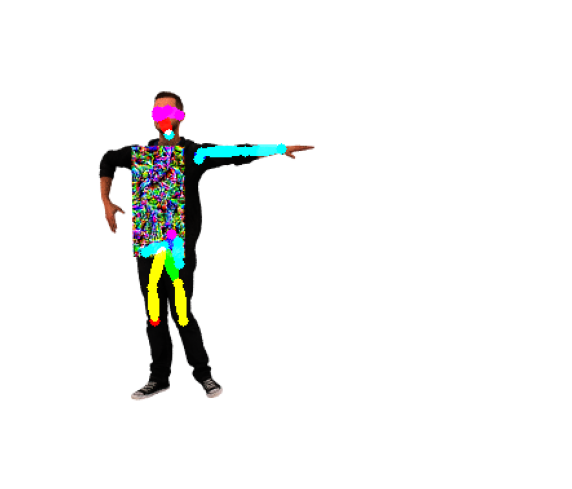

In [9]:
rendering_torch_np =  rendering_torch[:, :, PERMUTE_BGR].cpu().numpy()

canvas = copy.deepcopy(rendering_torch_np)
canvas = util.draw_bodypose(canvas, candidate, subset)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(canvas[:, :, [2, 1, 0]])
ax.axis('off')